In [1]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from Newton_model_numba import wrappedNewton, newtonRaphsonFT

In [2]:
class ComplexRootMeanSquaredError_harmonics(pints.ProblemErrorMeasure):
    def __init__(self, problem, model, Hz_interval, times):
        super(ComplexRootMeanSquaredError_harmonics, self).__init__(problem)

        if not isinstance(problem, pints.SingleOutputProblem):
            raise ValueError(
                'This measure is only defined for single output problems.')
        
        self.FT_values = model.FT_and_reduce_to_harmonics_4_to_12(self._values)
        self.harmonic_spacing = model.harmonic_spacing(self._values, times)
        print('harmonic_spacing (480): ', self.harmonic_spacing)
        self.freq = model.frequencies_for_harmonics_4_to_12(times =times)
        x = np.where(self.freq < model.freq*4)
        self.mid_point_index = x[0][-1] - 4
        print('mid_point_index (89): ', self.mid_point_index)
        self.index_window = int(np.round(model.index_distance_covering(Hz_interval, times)))
        print('index_window (32): ', self.index_window)
        self.data_dims = self.FT_values.shape[0]

        # np.absolute takes the element wise absoulte value of real numbers, 
        # and the element-wise modules/eulcdiean norm/ absoulte value of comlex numbers
        # i.e for: z = a +bi
        # |z| = sqrt(a^2+b^2)

    def __call__(self, x):

        simulation = self._problem.evaluate(x)
        reduced_FT_sim = model.FT_and_reduce_to_harmonics_4_to_12(simulation)

        low = int(self.mid_point_index - self.index_window)
        mid = int(self.mid_point_index)
        high = int(self.mid_point_index+ self.index_window + 1)

        total_complex_diff = 0.0
        harmonic = 4   
        while high <= self.data_dims:
            sim_harmonic = reduced_FT_sim[low:high]
            exp_harmonic = self.FT_values[low:high]

            # plt.figure(figsize=(18,10))
            # plt.title("simulation FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq, np.log10(self.FT_values),'k', label='experimental harm 4 -12')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            # plt.figure(figsize=(18,10))
            # plt.title("simulated on experimental FT")
            # plt.ylabel("amplituide")
            # plt.xlabel(xaxislabel)
            # plt.plot(self.freq[low:high], np.log10(exp_harmonic),'b', label='experimental_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(self.FT_values[mid]),'kX', label='harmonic_center')
            # plt.plot(self.freq[low:high], np.log10(sim_harmonic),'r', label='simulated_harmonic_'+str(harmonic))
            # plt.plot(self.freq[mid], np.log10(reduced_FT_sim[mid]),'cX', label='harmonic_center')
            # plt.legend(loc='best')
            # plt.show()

            kaiser_window = np.kaiser(exp_harmonic.shape[0], 0)

            complex_diff = sim_harmonic - exp_harmonic

            windowed = np.multiply(kaiser_window,complex_diff)

            total_complex_diff = total_complex_diff + windowed

            # increasing indexing
            high = high + self.harmonic_spacing
            mid = mid + self.harmonic_spacing
            low = low + self.harmonic_spacing

            harmonic = harmonic + 1

        # complex_diff = reduced_FT_sim - self.FT_values

        # magnatuide = np.absolute(complex_diff)

        magnatuide = np.absolute(total_complex_diff)

        squares = np.square(magnatuide)

        sumed = np.sum(squares)

        return np.sqrt(sumed)

In [3]:
# # specifing files and model 
# # specifing data location and folder for outputs

# Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

# data_file_names = ['9_1b_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0',
#                     '9 150_1_cv_current_reduced_0', '9 150_1_cv_current_reduced_0']

# experiment_folder = ['9_1b', '9 150_1',
#                      '9 150_1', '9 150_1',
#                      '9 150_1', '9 150_1']


# startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
# revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
# uncomp_resis_list = [3.25459258134767921e+01, 5.37315648829909520e+01, 7.08611444464832800e+01, 9.96182105930900406e+01, 1.21158504446797167e+02, 8.49461271867468355e+01]

# cap_params_list = [[1.86297231895378234e-04,  1.39822668111257240e-04,  3.70334763842398995e-04,  1.95151458630165057e-04,
#                     1.89160175800536629e-04,  1.72641582414570635e-04,  4.39360685286188006e-04,  2.43245044482993467e-04,
#                     -6.47033620007000394e+01],

#                     [1.94632384807037420e-04,  1.09253279202811606e-04,  2.88119296913558502e-04,  1.26365659832472976e-04,
#                     2.02905524533143831e-04,  1.80802994708567557e-04,  4.31389682179686342e-04,  2.20819252636918900e-04,
#                     -6.47033294616361019e+01],

#                     [2.04723750338681946e-04,  2.31336124514676302e-05,  6.72508062131533472e-05, -3.52789052587041763e-05,
#                     2.19537063820266680e-04,  1.36486944707261103e-04,  2.84492337211128500e-04,  9.96760436029462717e-05,
#                     -6.47033565846734575e+01],

#                     [2.31095670596632297e-04, -3.33935918269465505e-05,  2.61213767197990623e-05, -4.37105855050501238e-05,
#                     2.48585910357163357e-04,  8.43384306423355847e-05,  2.31490537079119671e-04,  7.27245330412529863e-05,
#                     -6.47034052381796130e+01],

#                     [2.10391107458934992e-04, -1.67952604491567012e-04, -2.27521114816858663e-04, -1.82193875674134206e-04,
#                     2.37152182054913105e-04, -1.71348627672825594e-05,  1.08690359778462926e-05, -5.80862929614741437e-05,
#                     -6.47034055661957552e+01],
                    
#                     [1.66897412567862006e-04, -3.31979915125576596e-04, -5.19143040976281084e-04, -3.20477836314988726e-04,
#                     2.13029444583132078e-04, -9.50966568724915390e-05, -1.66949344271613391e-04, -1.49813542866588539e-04,
#                     -6.47034179321291987e+01]
#                     ]

# # know paramteres for 9 150_1_cv_current_reduced_2
# freq = 8.977950e+00
# rateOfPotentialChange = -22.35174e-3

# deltaepislon = 150.0E-3
# electrode_area = 0.03
# electode_coverage = 6.5e-12


# Hz_interval_fitting_interval = 0.8

experimental data:  Data/processed/220415/ph4 2m nacl 25oC/ac/9_2b/9_2b_cv_current_reduced_0.txt
x[0][-1]:  482
y[0][0]:  483
z[0]:  []


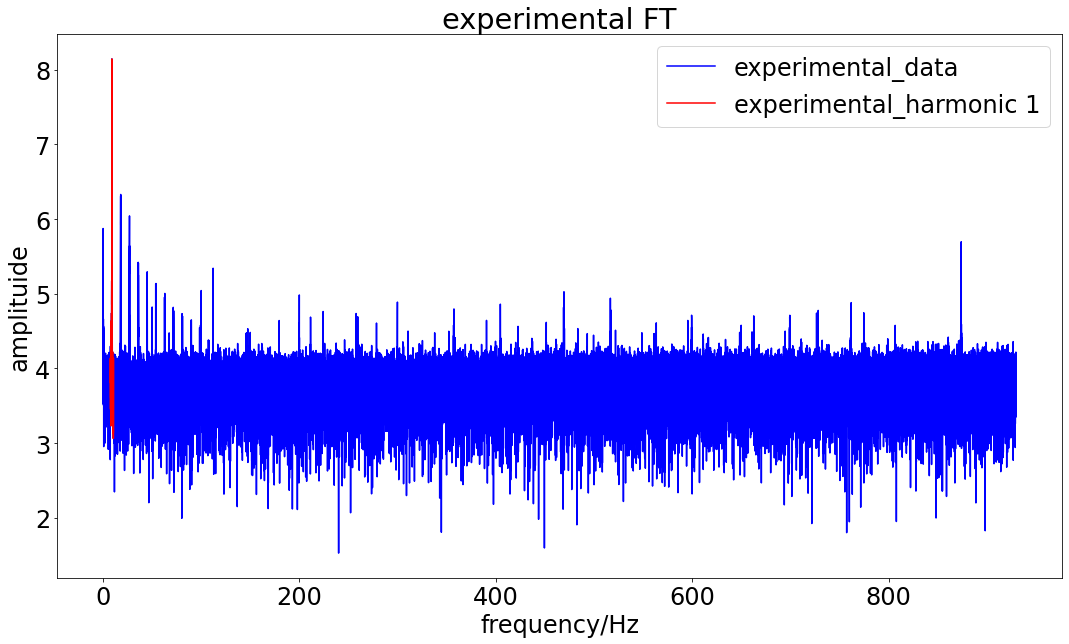

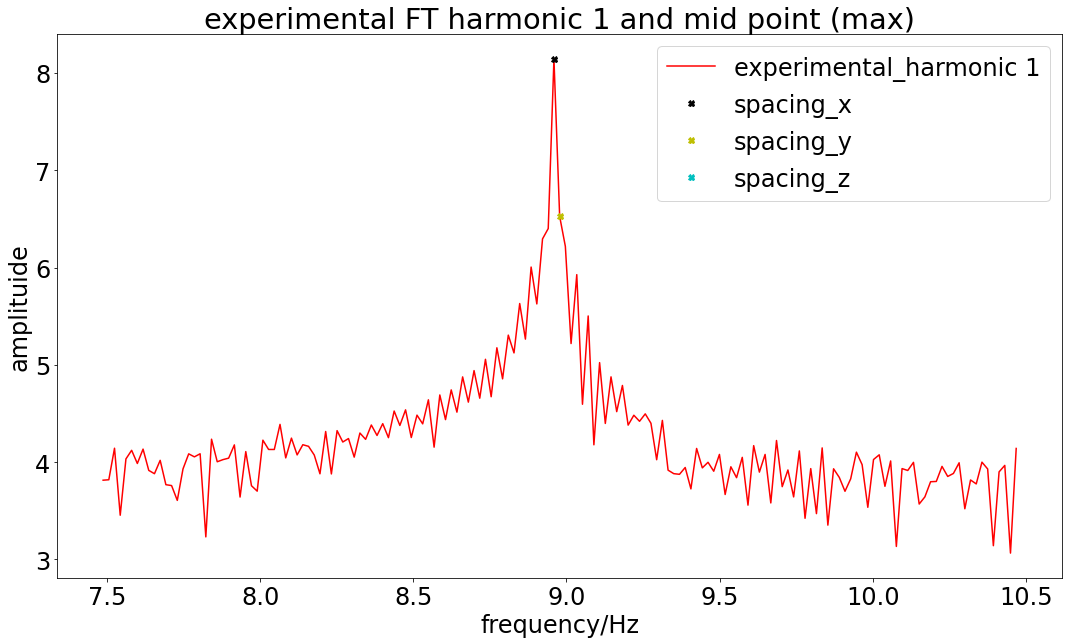

1.9  20:26.6
1660  14949  366241.9  20:41.4
1676  15084  366241.9  20:52.7
Halting: No significant change for 200 iterations.
random starting points:  [ 1.39012268e+03  1.93243542e+03 -4.00630905e-01 -4.93681842e-01
 -2.15633724e-01  3.95726650e+00]
         Found solution: 
 3.99999999972875139e+03  :kappa0_1
 3.24850121147983373e+00  :kappa0_2
-3.40186270630099208e-01  :epsilon0_1
-4.83160331789427466e-01  :epsilon0_2
-1.46899386229788487e-02  :mew
 1.73964679957539592e+00  :zeta
lower_bounds:  [ 0.     0.    -0.53  -0.53  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -1.70e-01 -1.70e-01  3.14e-01  1.00e+01]
Score at found solution: 366241.8850772852


**************************************** Run:  3  ****************************************


lower_bounds:  [ 0.     0.    -0.53  -0.53  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -1.70e-01 -1.70e-01  3.14e-01  1.00e+01]
random starting points:  [ 9.81997479e+02  9.18497786e+02 -3.65739771e-01 -4.32985495e-01
  1.43984913e

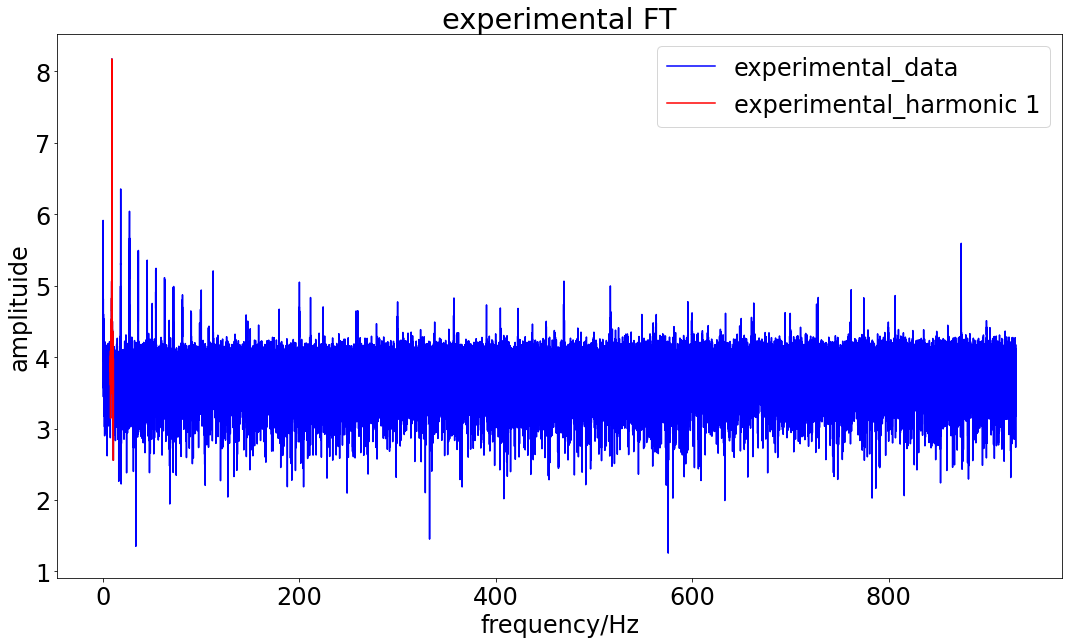

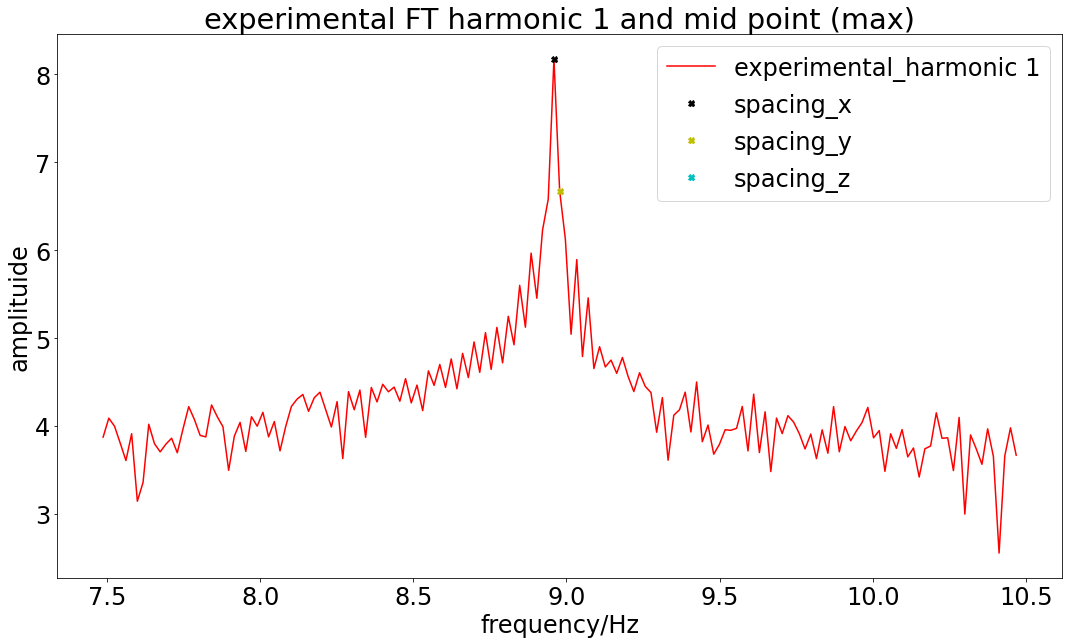

 369    927553.7   0:30.8
60    549    915796.9   0:45.9
80    729    914060     1:01.0
100   909    913929.2   1:15.9
120   1089   913824.7   1:30.8
140   1269   913812.6   1:45.7
160   1449   913807.6   2:01.1
180   1629   911797.1   2:15.9
200   1809   721880.8   2:31.0
220   1989   653939.3   2:45.9
240   2169   496303.3   3:00.9
260   2349   419110.3   3:15.9
280   2529   414584.6   3:30.8
300   2709   414541.5   3:45.9
320   2889   414539.4   4:00.9
340   3069   414539.3   4:16.0
360   3249   414539.3   4:30.9
380   3429   414539.3   4:45.8
400   3609   414539.3   5:01.0
420   3789   414539.3   5:16.1
440   3969   414539.3   5:31.1
460   4149   414539.3   5:46.1
480   4329   414539.3   6:01.1
500   4509   414539.3   6:16.2
520   4689   414539.3   6:31.1
540   4869   414539.3   6:46.1
560   5049   414539.3   7:01.0
580   5229   414539.3   7:16.9
600   5409   414539.3   7:31.7
620   5589   414539.3   7:46.9
640   5769   414539.3   8:02.4
660   5949   414539.3   8:17.5
680   6129   

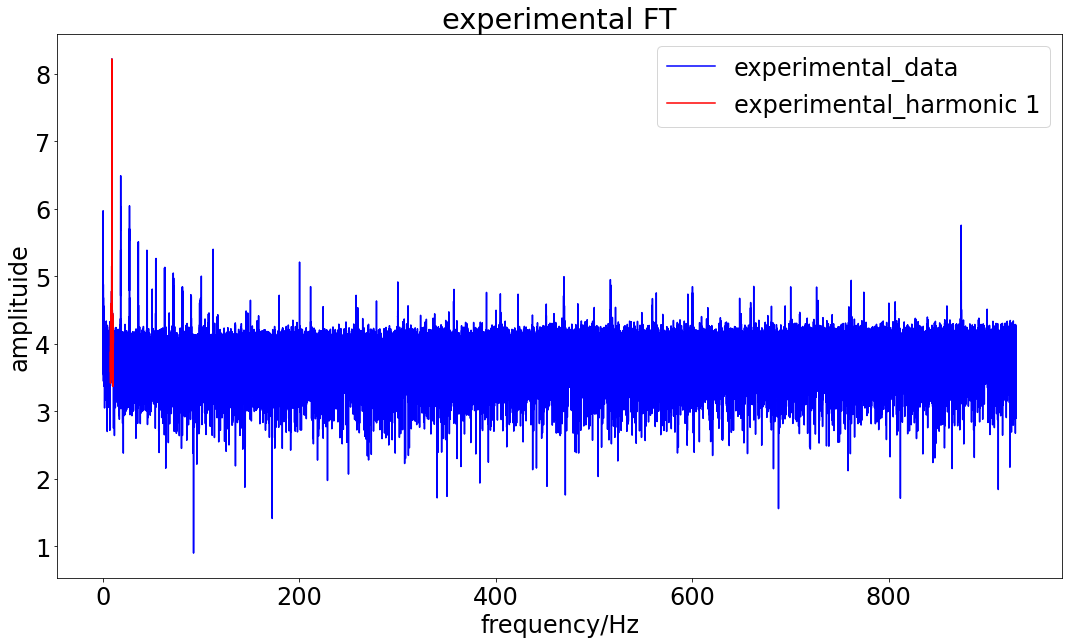

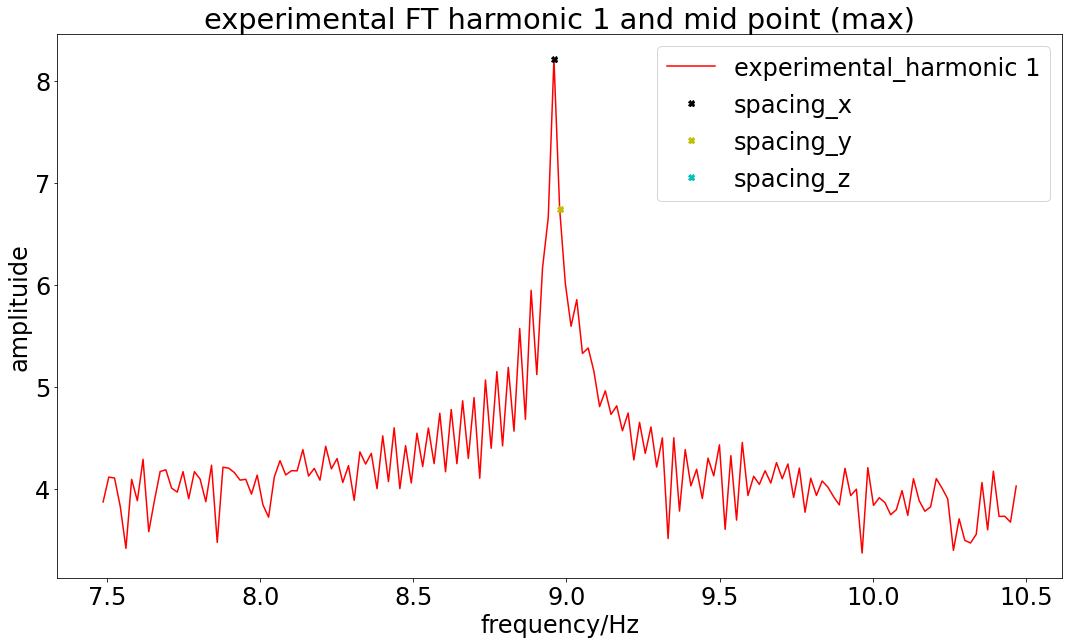

.33543847e-01  1.21374968e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      1353844    0:00.9
1     18     1325658    0:01.7
2     27     1304989    0:02.5
3     36     1304989    0:03.2
20    189    1268580    0:16.1
40    369    1266607    0:31.5
60    549    1263838    0:46.9
80    729    1263773    1:01.8
100   909    1263753    1:17.2
120   1089   1263749    1:32.3
140   1269   1263748    1:47.7
160   1449   1263747    2:02.6
180   1629   1263747    2:17.9
200   1809   1263747    2:33.1
220   1989   1263747    2:48.3
240   2169   1263747    3:03.4
260   2349   1263747    3:18.7
280   2529   1263747    3:33.9
300   2709   1263747    3:49.0
320   2889   1263747    4:04.1
340   3069   1263747    4:19.3
360   3249   1263747    4:34.8
380   3429   1263747    4:49.9
400   3609   1263747    5:05.3
420   3789   1263747    5:20.4
440   3969 

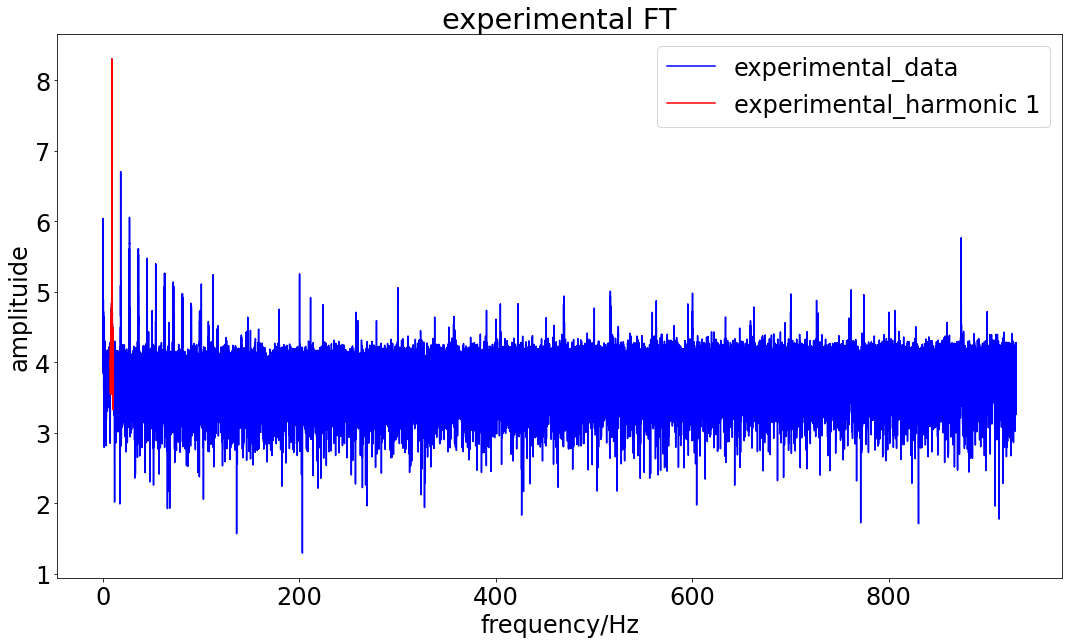

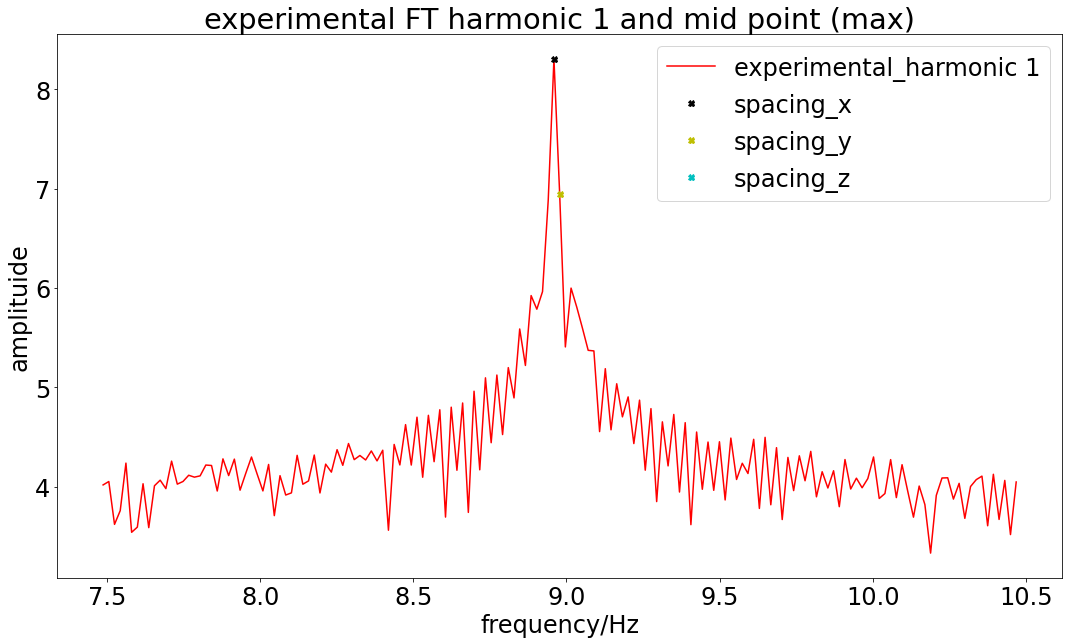

0  :zeta
lower_bounds:  [ 0.     0.    -0.68  -0.68  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -3.20e-01 -3.20e-01  3.14e-01  1.00e+01]
Score at found solution: 533608.8997950936


**************************************** Run:  4  ****************************************


lower_bounds:  [ 0.     0.    -0.68  -0.68  -0.314  0.   ]
upper_bounds:  [ 4.00e+03  4.00e+03 -3.20e-01 -3.20e-01  3.14e-01  1.00e+01]
random starting points:  [ 7.81509834e+02  1.97463819e+02 -6.18555921e-01 -6.68411756e-01
  2.40581614e-01  9.55311655e+00]
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 8 worker processes.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      6061568    0:00.9
1     18     5691564    0:01.8
2     27     5691564    0:03.1
3     36     5691564    0:04.1
20    189    1489454    0:16.9
40    369    1289634    0:32.2
60    549    1259082    0:47.8
80    729    991549.7   1:03.0
100   909    991549.7   1:

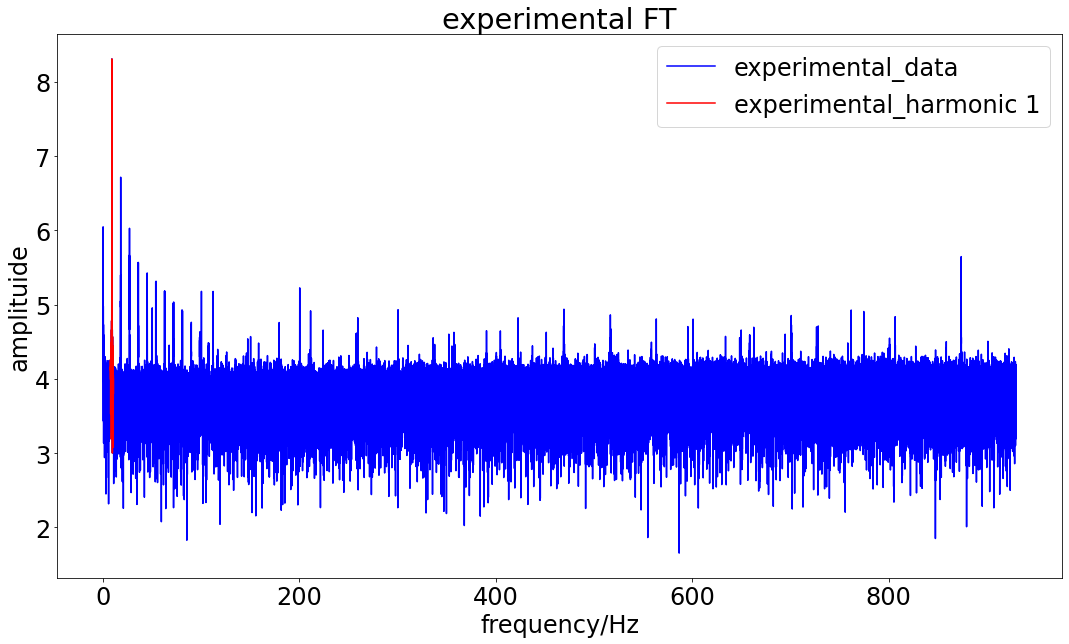

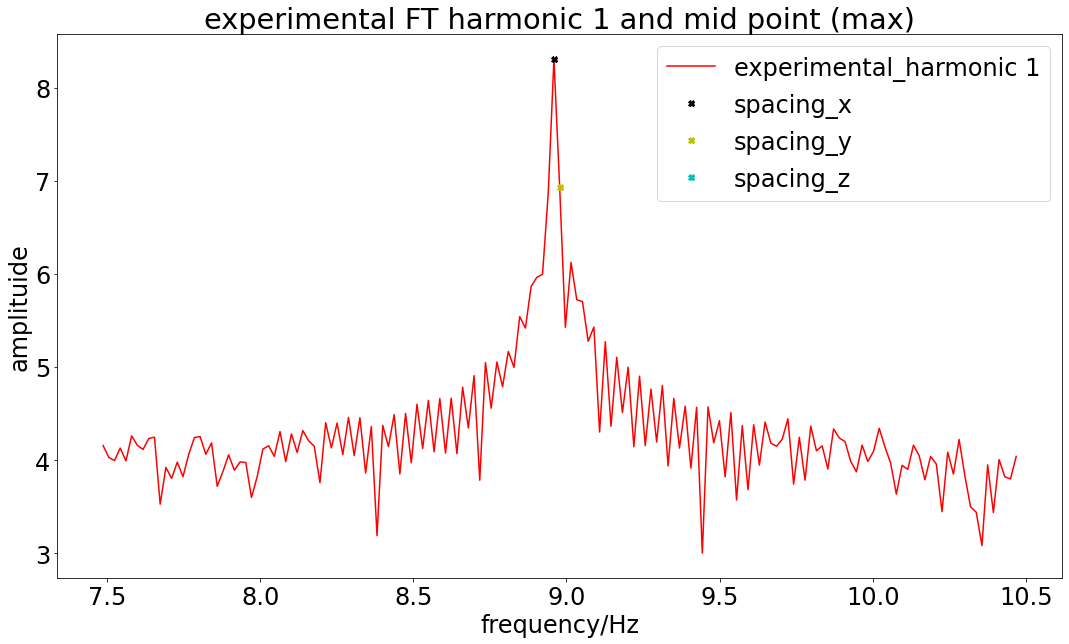

20   3789   538452.5   5:25.3
440   3969   538452.5   5:40.7
460   4149   538452.5   5:56.4
480   4329   538452.5   6:12.0
500   4509   538452.5   6:27.3
520   4689   538452.5   6:43.0
540   4869   538452.5   6:58.4
560   5049   538452.5   7:13.8
580   5229   538452.5   7:29.3
600   5409   538452.5   7:44.7
620   5589   538452.5   8:00.1
640   5769   538452.5   8:15.4
660   5949   538452.5   8:30.9
680   6129   538452.5   8:46.7
700   6309   538452.5   9:02.0
720   6489   538452.5   9:17.5
740   6669   538452.5   9:33.2
760   6849   538452.5   9:48.5
780   7029   538452.5  10:03.9
800   7209   538452.5  10:19.5
820   7389   538452.5  10:35.1
840   7569   538452.5  10:50.4
860   7749   538452.5  11:05.8
880   7929   538452.5  11:21.1
900   8109   538452.5  11:36.8
920   8289   538452.5  11:52.3
940   8469   538452.5  12:07.6
960   8649   538452.5  12:23.0
980   8829   538452.5  12:38.8
1000  9009   538452.5  12:54.2
1020  9189   538452.5  13:09.5
1040  9369   538452.5  13:25.2
1060  954

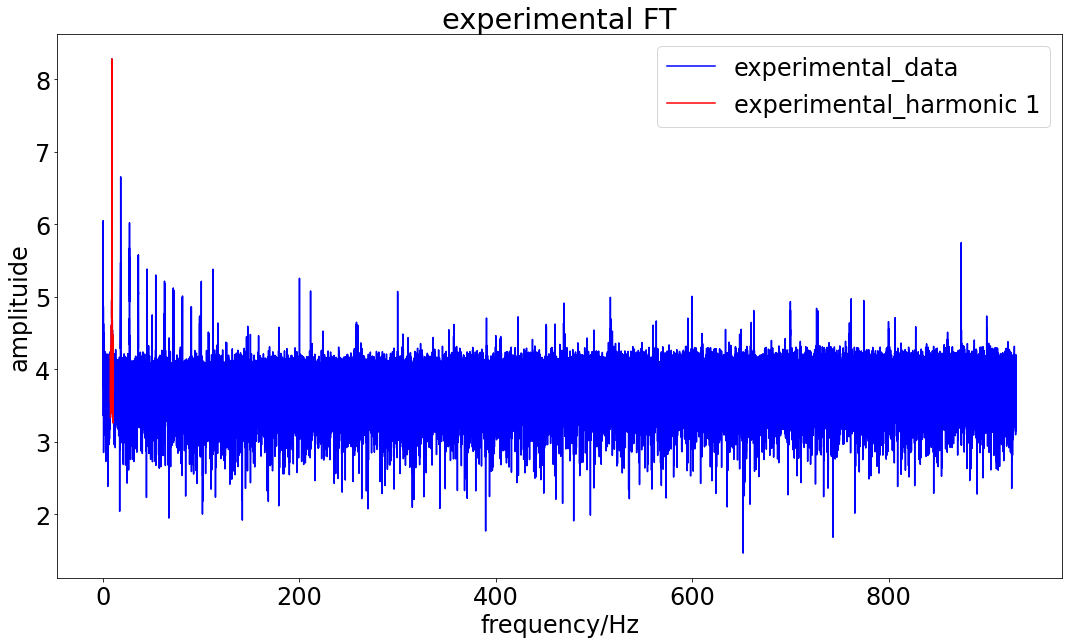

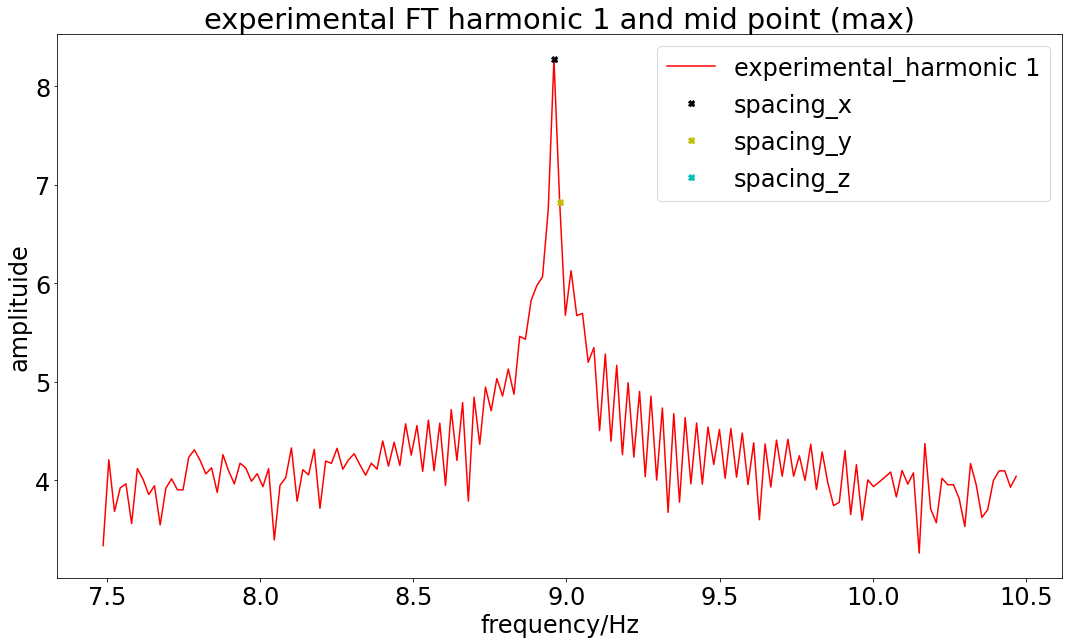

663.5   2:33.9
220   1989   473977.9   2:49.2
240   2169   467950.7   3:04.6
260   2349   453448.1   3:20.1
280   2529   437784.9   3:35.5
300   2709   425292.6   3:50.8
320   2889   420511.8   4:06.1
340   3069   415741.2   4:21.3
360   3249   414366.1   4:36.5
380   3429   413849     4:52.3
400   3609   413756.9   5:07.3
420   3789   413733.8   5:22.6
440   3969   413731.4   5:37.9
460   4149   413731.3   5:53.2
480   4329   413731.2   6:08.4
500   4509   413731.2   6:23.8
520   4689   413731.2   6:39.2
540   4869   413731.2   6:54.4
560   5049   413731.2   7:09.7
580   5229   413731.2   7:25.0
600   5409   413731.2   7:40.2
620   5589   413731.2   7:55.5
640   5769   413731.2   8:11.0
660   5949   413731.2   8:26.3
680   6129   413731.2   8:41.7
700   6309   413731.2   8:57.1
720   6489   413731.2   9:12.3
740   6669   413731.2   9:27.7
760   6849   413731.2   9:43.2
780   7029   413731.2   9:58.6
800   7209   413731.2  10:14.2
820   7389   413731.2  10:29.9
840   7569   413731.2  1

In [4]:
             
for index in range(6):
    # specifing files and model 
    # specifing data location and folder for outputs

    Phfolder = ['ph4 2m nacl 25oC','ph5 2m nacl 25oC','ph6 2m nacl 25oC','ph7 2m nacl 25oC','ph8 2m nacl 25oC','ph9 2m nacl 25oC']

    data_file_names = ['9_2b_cv_current_reduced_0', '9 150_2_cv_current_reduced_0',
                        '9 150_2_cv_current_reduced_0', '9 150_2_cv_current_reduced_0',
                        '9 150_2_cv_current_reduced_0', '9 150_2_cv_current_reduced_0']

    experiment_folder = ['9_2b', '9 150_2',
                        '9 150_2', '9 150_2',
                        '9 150_2', '9 150_2']


    startPotential_list = [-50.0E-3, -100.0E-3, -150.0E-3, -200.0E-3, -250.0E-3, -300.0E-3]
    revPotential_list = [-650.0E-3, -700.0E-3, -750.0E-3, -800.0E-3, -850.0E-3, -900.0E-3]
    uncomp_resis_list = [1.47088326071792803e+01, 2.21591420471205467e+01, 4.91093361010766216e+01, 9.88663950115430197e+01, 1.17141412103745225e+02, 7.05893059187900036e+01]

    cap_params_list = [[1.88356619144636639e-04,  1.61804371769421872e-04,  4.17733388850252121e-04,  2.26950999142877443e-04,
                        1.89087026300671711e-04,  1.73822416927598691e-04,  4.40681793441882567e-04,  2.44766642311555283e-04,
                        -6.47033934667446857e+01],

                        [2.01046156782550537e-04,  1.65326024461745925e-04,  4.01459905824463241e-04,  2.00358643382299133e-04,
                        2.03045918441899009e-04,  1.85822669286993215e-04,  4.39025096642325441e-04,  2.26832628960485418e-04,
                        -6.47033925917737207e+01],

                        [2.16710588046379227e-04,  1.18587312677610442e-04,  2.52608787408844159e-04,  7.92142410218933928e-05,
                        2.19857070006249854e-04,  1.42935878591222629e-04,  2.93898783235907457e-04,  1.06914168331613676e-04,
                        -6.47033931723459972e+01],

                        [2.44250807179399601e-04,  6.11685862574168609e-05,  1.93117458549958449e-04,  4.98778398733202340e-05,
                        2.48408084911049259e-04,  8.53541772431502203e-05,  2.27631392740451979e-04,  7.04359246700657620e-05,
                        -6.47034019846601183e+01],

                        [2.31361586802034125e-04, -4.48807100047666401e-05, -3.17430159210201285e-05, -8.10907246275303136e-05,
                        2.37894816520232988e-04, -1.24229210269697493e-05,  1.25449359788839913e-05, -5.71844062328632661e-05,
                        -6.47034045743019561e+01],
                        
                        [2.02672433283549163e-04, -1.43761435923088162e-04, -2.41139580970232883e-04, -1.87439735556619918e-04,
                        2.14689941993297172e-04, -8.42760263126164644e-05, -1.55376612342293012e-04, -1.43409092569439685e-04,
                        -6.47034000628126478e+01]
                        ]

    # know paramteres for 9 150_1_cv_current_reduced_2
    freq = 8.977950e+00
    rateOfPotentialChange = -22.35174e-3

    deltaepislon = 150.0E-3
    electrode_area = 0.03
    electode_coverage = 6.5e-12


    Hz_interval_fitting_interval = 0.8

    data_name = data_file_names[index]
    file_name = data_name + '.txt'
    folder = os.path.join('Data', 'processed')
    folder = os.path.join(folder, '220415')
    folder = os.path.join(folder, Phfolder[index])
    folder = os.path.join(folder, 'ac')
    folder = os.path.join(folder, experiment_folder[index])
    data_file = os.path.join(folder, file_name)

    # creating file for output
    fitting_technique = 'harmonic '
    output_file_name = fitting_technique + 'fitting_for_faradaic_data'
    output_file_name = output_file_name + '.txt'
    folder = os.path.join(folder, 'faradaic_fitting')
    folder = os.path.join(folder, 'harmonics4-12')
    f= open(os.path.join( folder, output_file_name),"w")

    # opening data
    experimental_data = pd.read_csv(data_file, sep='\t')

    exp_times = np.asarray(experimental_data.time)
    exp_current = np.asarray(experimental_data.current)

    # know paramteres that are data specific
    inital_current = exp_current[index]
    startPotential= startPotential_list[index]
    revPotential = revPotential_list[index]
    uncomp_resis = uncomp_resis_list[index]

    # delacring capactiance parameters
    # (gamma0, gamma1, gamma2, gamma3, omega)
    cap_params = cap_params_list[index][:]

    measurements = exp_current.shape[0]
    # print('measurements: ', measurements)
    # if measurements%2 !=0:
    #     print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)

    # declaring model to obtain non dimensinalise constant
    trial = newtonRaphsonFT(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                            rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage)

    # non-diming experimental data
    exp_current_dimless = exp_current/trial.I0

    # model for optimsation
    model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                            rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                            initaldiscard = 0.030, enddiscard = 0.876, cap_params=cap_params)

    real_parameters = model.suggested_parameter()
    parameter_order = ['kappa0_1', 'kappa0_2', 'epsilon0_1', 'epsilon0_2', 'mew', 'zeta']
    real_parameters = np.asarray(real_parameters)
    real_parameters = np.asarray([4.00000000000000000e+03,  3.99999999972441947e+03, -5.03044038352866596e-01, -1.69999999999999984e-01,  2.18249911855460221e-01,  4.90950349026095523e-01])
    f.write("experimental data: " + data_file + "\r\n")
    print('experimental data: ',data_file)

    # checking loaction of harmonics 1-4
    half_of_measuremnts = int(measurements/2)

    # full FT and frequencies
    full_sim = np.fft.fft(exp_current_dimless)
    half_full_sim = full_sim[:half_of_measuremnts]

    freq_org = np.fft.fftfreq(exp_times.shape[-1], d= exp_times[1])
    freq_org=freq_org[:half_of_measuremnts]

    # regional FT and Frequency

    freq = model.frequencies_for_harmonics_4_to_12(exp_times)

    harmonics1To4 = model.FT_and_reduce_to_harmonics_4_to_12(exp_current_dimless)

    xaxislabel = "frequency/Hz" # "potential/V"
    plt.figure(figsize=(18,10))
    plt.title("experimental FT")
    plt.ylabel("amplituide")
    plt.xlabel(xaxislabel)
    plt.plot(freq_org, np.log10(half_full_sim),'b', label='experimental_data')
    plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment FT data and range 4-12.pdf'))
    plt.close()

    xaxislabel = "frequency/Hz" # "potential/V"
    plt.figure(figsize=(18,10))
    plt.title("experimental harmonics 1 -4 ")
    plt.ylabel("amplituide")
    plt.xlabel(xaxislabel)
    plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
    plt.legend(loc='best')
    plt.savefig(os.path.join( folder, 'experiment FT harmonics 4-12.pdf'))
    plt.close()

    # declaring problem

    problem = pints.SingleOutputProblem(model, exp_times, exp_current_dimless)

    score = ComplexRootMeanSquaredError_harmonics(problem, model, Hz_interval=Hz_interval_fitting_interval, times=exp_times)

    e_min = model.startPotential + 0.2*(model.revPotential - model.startPotential)
    e_max = model.startPotential + 0.8*(model.revPotential - model.startPotential)

    lower_bounds = np.asarray([0.0, 0.0, e_max, e_max, -0.314, 0.0])#, 0.1])
    upper_bounds = np.asarray([4000.0, 4000.0, e_min, e_min, 0.314, 10])#, 4.5])

    boundaries = pints.RectangularBoundaries(lower_bounds, upper_bounds)

    # optimisimg

    total_runs = 10
    dims = real_parameters.shape
    print('dims: ', dims)
    print('dims[0]: ', dims[0])
    params_matrix = np.zeros((total_runs, dims[0]))
    for run in range(total_runs):
            
        if run > 0:
            f = open(os.path.join( folder, output_file_name),"a")

        f.write("\r\n\r\n" + 40*"*" + " Run: %d " % run + 40*"*" + "\r\n\r\n")
        print('\n\n' + 40*"*" + ' Run: ', run, ' ' + 40*"*" + '\n\n')
        accuracy = (2 + run)
        # f.write("Threshold for stopping: %e\r\n\r\n" % pow(10,-accuracy))
        # print('Threshold for stopping: ', pow(10,-accuracy))

        ranges = upper_bounds - lower_bounds 

        starting_points = np.copy(lower_bounds)
        for i in range(len(ranges)):
            starting_points[i] += ranges[i] * np.random.uniform(low = 0.001, high = 0.999)
        
        print('lower_bounds: ', lower_bounds)
        print('upper_bounds: ', upper_bounds)

        # if run == 0 or run == 1:
        #     starting_points = [2.57047207348942493e+03, 3.99999999768745511e+03,
        #                        -4.06092122495331220e-01, -3.85232125319061813e-01,
        #                        1.30576834023528043e-02,  4.89063759242589380e-01]
        print('random starting points: ', starting_points)

        f.write("lower_bounds: ")
        for i in lower_bounds:
            f.write("%e, " % i)
        f.write("\r\nupper_bounds: ")
        for i in upper_bounds:
            f.write("%e, " % i)
        f.write("\r\nRandom starting_points: ")
        for i in starting_points:
            f.write("%e, " % i)
        f.write("\r\n")

        # transformation
        transform = pints.RectangularBoundariesTransformation(boundaries)

        # optimising boundaries=boundaries,
        opt = pints.OptimisationController(
            score,
            x0=starting_points,
            method=pints.CMAES,
            transform = transform)

            
        #opt.set_max_unchanged_iterations(iterations=50, threshold=pow(10,-accuracy))
        #opt.set_max_unchanged_iterations(iterations=100)
        opt.set_parallel(parallel=True)
        #opt.set_max_iterations(iterations=1)
        opt.set_log_interval(iters=20, warm_up=3)
        #opt.set_threshold(threshold=-??????)
        
        found_parameters, found_value =  opt.run()
            #CMAES, PSO, SNES, XNES
        # output results

        print('random starting points: ', starting_points)

        f.write("Found solution: ")
        for k, x in enumerate(found_parameters):
            f.write(pints.strfloat(x) +", ")

        print('         Found solution: ')
        name = 0
        for k, x in enumerate(found_parameters):
            print( pints.strfloat(x) +'  :' + parameter_order[name])
            name = name + 1

        print('lower_bounds: ', lower_bounds)
        print('upper_bounds: ', upper_bounds)

        f.write("\r\n\r\nFound solution:\r\n")
        name = 0
        for k, x in enumerate(found_parameters):
            f.write(pints.strfloat(x) + '  :' + parameter_order[name]+ '\r\n')
            name = name + 1

        params_matrix[run, :] = found_parameters

        # plotting current for found parameters over the experimentally data

        xaxis = exp_times #model.potentialRange
        xaxislabel = "time/s" # "potential/V"
        solution = model.simulate(found_parameters, exp_times)


        plt.figure(figsize=(18,10))
        plt.title("optimised and experimental values")
        plt.ylabel("Fourier transformed current/dimless")
        plt.xlabel(xaxislabel)
        plt.plot(xaxis, exp_current_dimless,'r', label='experiment')
        plt.plot(xaxis ,solution,'b', label='optimised_'+str(found_parameters[0])+'_'+str(found_parameters[1]))
        plt.legend(loc='best')
        plt.savefig(os.path.join( folder, 'experiment against optimised with potential run '+str(run)+'.pdf'))
        #plt.show()
        plt.close()

        print("Score at found solution:", score(found_parameters))
        f.write("Score at found solution: %.16e\r\n" % score(found_parameters))

        run += run
    f.close()

In [5]:
# trial_simulation = model.simulate(real_parameters, exp_times)

# xaxislabel = "time/s" # "potential/V"
# plt.figure(figsize=(18,10))
# plt.title("trial sim vs experimental")
# plt.ylabel("amplituide")
# plt.xlabel(xaxislabel)
# plt.plot(exp_times, exp_current_dimless,'b', label='exp_current_dimless')
# plt.plot(exp_times, trial_simulation,'r', label='trial_simulation')
# plt.legend(loc='best')
# plt.show()

In [6]:
# # checking harmonics are in the right place

# print_all_harmonics = False
# print_these_harmonics = [4,5,6,7,8,10,12,13]
# model.ploting_harmonic(experimental_data = exp_current_dimless, times = exp_times, parameter_for_sim = real_parameters, Hz_interval = 0.8, print_all_harmonics= print_all_harmonics, print_these_harmonics = print_these_harmonics, check_FT_harmonic_locations = True, print_harmonics = False)